<a href="https://colab.research.google.com/github/Patri04/PyTorch-Course/blob/main/3_Classificatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *HELPER FUNCTIONS*

In [ ]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def plot_decision_boundary(model: torch.nn.Module,
                           X: torch.Tensor,
                           y: torch.Tensor,
                           from_logits: bool = False):
    """
    Plots the decision boundary of a model on data X with labels y.

    Args:
      model (torch.nn.Module): The model.
      X (torch.Tensor): Input features.
      y (torch.Tensor): Labels.
      from_logits (bool): If True, the model outputs raw logits and we need to apply
                          sigmoid (for binary) or softmax (for multi-class).
                          If False (default), we assume the model already outputs
                          probabilities.
    """
    # Move everything to CPU for plotting
    model = model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Set up the prediction grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create the feature matrix to predict on
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Get model outputs
    model.eval()
    with torch.inference_mode():
        outputs = model(X_to_pred_on)
        # If the model returns logits, convert them to probabilities
        if from_logits:
            if len(torch.unique(y)) > 2:  # Multi-class
                outputs = torch.softmax(outputs, dim=1)
            else:  # Binary classification
                outputs = torch.sigmoid(outputs)

    # Convert outputs to predicted labels
    if len(torch.unique(y)) > 2:  # Multi-class
        y_pred = outputs.argmax(dim=1)
    else:  # Binary classification (assuming outputs are probabilities)
        y_pred = torch.round(outputs)

    # Reshape the predictions and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

# **Binary Classification**

Classification is a problem of predicting if something is one thing or another.
The Machine Learning library sklearn has a lot of datasets useful for classification training.

Binary classification is the task of classifying the elements of a set into one of two groups.

*Example: blue - red dots*

**1) Data preparation and visualization**

In [ ]:
#Binary classification input data
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, Y = make_circles(n_samples, noise = 0.03, random_state = 42)                 #Input: X == (x1, x2)                                                                             #Output: Y == 1 or 0

In [ ]:
#Dataframe creation
import pandas as pd
circles = pd.DataFrame({ "X1" : X[:,0], "X2" : X[:,1], "label": Y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


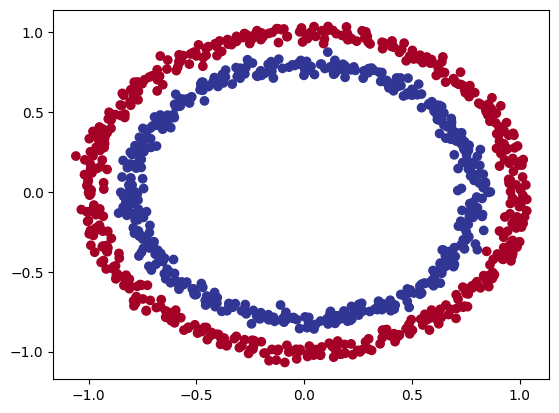

In [ ]:
#Dataframe visualization
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0], y = X[:,1], c = Y, cmap = plt.cm.RdYlBu)

In [ ]:
#Data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

In [ ]:
#Splitting data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size = 0.2, random_state = 42)

**2) Model building**

We want to build a model to classify blue and red dots.

There are many ways to build a model using PyTorch functions and shortcuts.

In [ ]:
#Setting up device agnostic code
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Creating model V0
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features = 5)                  #layer 1
    self.layer2 = nn.Linear(in_features= 5, out_features = 1)                   #layer 2
    self.sigmoid = nn.Sigmoid()                                                 #layer 3

  def forward(self, x):
    return self.sigmoid(self.layer2(self.layer1(x)))                            #input -> layer 1 -> layer 2 -> sigmoid -> output

model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
#Creating model V1
model1 = nn.Sequential(nn.Linear(in_features = 2, out_features = 5),            #layer 1
                    nn.Linear(in_features = 5, out_features = 1),               #layer 2
                    nn.Sigmoid()                                                #layer 3
                    ).to(device)
model1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
  (2): Sigmoid()
)

In [ ]:
#Creating model V2
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.modelV2_forward = nn.Sequential(nn.Linear(in_features = 2, out_features = 5),     #layer 1
                                         nn.Linear(in_features = 5, out_features = 1),     #layer 2
                                         nn.Sigmoid())                                     #layer 3


  def forward(self, x):
    return self.modelV2_forward(x)

model2 = CircleModelV2().to(device)
model2

CircleModelV2(
  (modelV2_forward): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [ ]:
#Predictions
with torch.inference_mode():
  untrained_preds = model0(X_test.to(device))                                   #PREDICTIONS BEFORE TRAINING
  print(f"First 10 predictions: {torch.round(untrained_preds[:10])}")
  print(f"First 10 labels: {Y_test[:10]}")

First 10 predictions: tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


**3) Model training**

In [ ]:
#Setting up loss function and optimizer
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(params = model0.parameters(), lr = 0.1)

In [ ]:
#Training and testing loop
epochs = 100
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in torch.arange(epochs):
  model0.train()

  Y_preds = model0(X_train).squeeze()
  loss = loss_fn(Y_preds, Y_train)
  acc = accuracy_fn(y_true = Y_train, y_pred = Y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  model0.eval()
  with torch.inference_mode():

    test_preds = model0(X_test).squeeze()

    test_loss = loss_fn(test_preds, Y_test)

    test_acc = accuracy_fn(y_true = Y_test, y_pred = test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69506 | Accuracy: 0.00% | Test loss: 0.69215 | Test accuracy: 0.00%
Epoch: 10 | Loss: 0.69463 | Accuracy: 0.00% | Test loss: 0.69225 | Test accuracy: 0.00%
Epoch: 20 | Loss: 0.69430 | Accuracy: 0.00% | Test loss: 0.69238 | Test accuracy: 0.00%
Epoch: 30 | Loss: 0.69404 | Accuracy: 0.00% | Test loss: 0.69252 | Test accuracy: 0.00%
Epoch: 40 | Loss: 0.69384 | Accuracy: 0.00% | Test loss: 0.69267 | Test accuracy: 0.00%
Epoch: 50 | Loss: 0.69367 | Accuracy: 0.00% | Test loss: 0.69281 | Test accuracy: 0.00%
Epoch: 60 | Loss: 0.69354 | Accuracy: 0.00% | Test loss: 0.69296 | Test accuracy: 0.00%
Epoch: 70 | Loss: 0.69343 | Accuracy: 0.00% | Test loss: 0.69310 | Test accuracy: 0.00%
Epoch: 80 | Loss: 0.69334 | Accuracy: 0.00% | Test loss: 0.69323 | Test accuracy: 0.00%
Epoch: 90 | Loss: 0.69327 | Accuracy: 0.00% | Test loss: 0.69335 | Test accuracy: 0.00%


In [ ]:
#Predictions
with torch.inference_mode():
  untrained_preds = model0(X_test.to(device))                                   #PREDICTIONS AFTER TRAINING
  print(f"First 10 predictions: {torch.round(untrained_preds[:10])}")
  print(f"First 10 labels: {Y_test[:10]}")

First 10 predictions: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]])
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


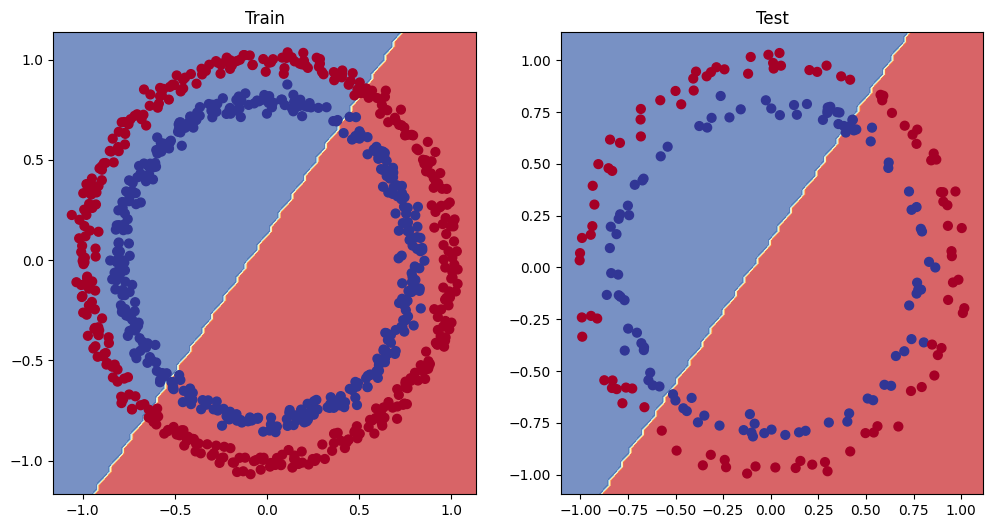

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, Y_test)

**4) Model improving**

We cab improve our model performance firstly changing its structure, add more layers or activations per layer.

Then we can use more specific and sofisticated techniques.

*Model with different structure nad non-linearity*

In [ ]:
#Creating model V3
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()

    self.modelV3_forward = nn.Sequential(nn.Linear(in_features = 2, out_features = 32),
                                         nn.ReLU(),
                                         nn.Linear(in_features = 32, out_features = 32),
                                         nn.ReLU(),
                                         nn.Linear(in_features = 32, out_features = 1),
                                         nn.Sigmoid())


  def forward(self, x):
    return self.modelV3_forward(x)

model3 = CircleModelV3().to(device)
model3

CircleModelV3(
  (modelV3_forward): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
#Setting up loss function and optimizer
loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(params = model3.parameters(), lr = 0.1)

In [ ]:
#Training model V3
epochs = 1000
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in torch.arange(epochs):
  model3.train()

  Y_preds = model3(X_train).squeeze()
  loss = loss_fn(Y_preds, Y_train)
  acc = accuracy_fn(y_true = Y_train, y_pred = Y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  model3.eval()
  with torch.inference_mode():

    test_preds = model3(X_test).squeeze()

    test_loss = loss_fn(test_preds, Y_test)

    test_acc = accuracy_fn(y_true = Y_test, y_pred = test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69594 | Accuracy: 0.00% | Test loss: 0.69616 | Test accuracy: 0.00%
Epoch: 100 | Loss: 0.68541 | Accuracy: 0.00% | Test loss: 0.68847 | Test accuracy: 0.00%
Epoch: 200 | Loss: 0.67661 | Accuracy: 0.00% | Test loss: 0.68253 | Test accuracy: 0.00%
Epoch: 300 | Loss: 0.66312 | Accuracy: 0.00% | Test loss: 0.67192 | Test accuracy: 0.00%
Epoch: 400 | Loss: 0.63877 | Accuracy: 0.00% | Test loss: 0.65120 | Test accuracy: 0.00%
Epoch: 500 | Loss: 0.59320 | Accuracy: 0.00% | Test loss: 0.61164 | Test accuracy: 0.00%
Epoch: 600 | Loss: 0.50786 | Accuracy: 0.00% | Test loss: 0.53506 | Test accuracy: 0.00%
Epoch: 700 | Loss: 0.36973 | Accuracy: 0.00% | Test loss: 0.40688 | Test accuracy: 0.00%
Epoch: 800 | Loss: 0.22415 | Accuracy: 0.00% | Test loss: 0.26520 | Test accuracy: 0.00%
Epoch: 900 | Loss: 0.13019 | Accuracy: 0.00% | Test loss: 0.16712 | Test accuracy: 0.00%


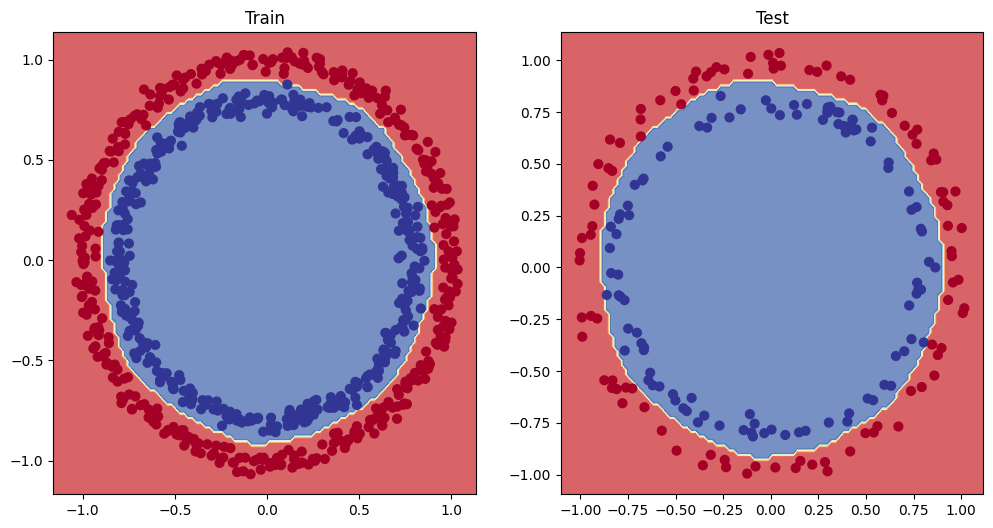

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, Y_test)

# **Multi-class  Classification**

Multiclass classification is the process of assigning entities with more than two classes. Each entity is assigned to one class without any overlap.

*Example: multi-color dots*

**1) Data creation**

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
NUM_SAMPLES = 1000
CLUSTER_STD = 1.5
RANDOM_SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Creating data
X_blob, Y_blob = make_blobs(n_samples = NUM_SAMPLES, n_features = NUM_FEATURES, centers = NUM_CLASSES, cluster_std = CLUSTER_STD, random_state = RANDOM_SEED)

In [ ]:
#Data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.float)

In [ ]:
#Data splitting
X_blob_train, X_blob_test, Y_blob_train, Y_blob_test = train_test_split(X_blob, Y_blob, test_size = 0.2, random_state = RANDOM_SEED)

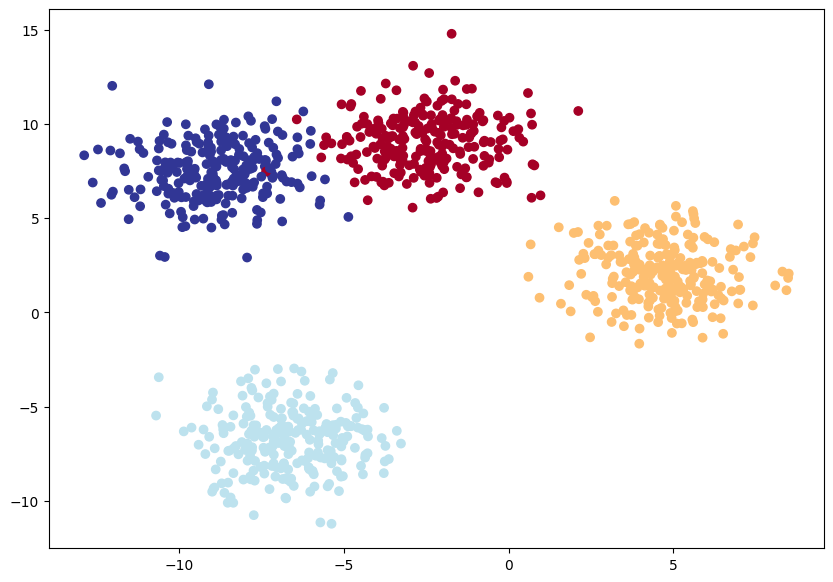

In [ ]:
#Data visualization
plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = Y_blob, cmap = plt.cm.RdYlBu)

**2) Model building**

In [ ]:
#Model building

class BlobModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    '''
    input_features: number of input features to the model
    output_features: number of output features of the model
    hidden_units: number of hidden units between layers
    '''
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features),
        nn.Softmax()
    )

  def forward(self, x):
    return self.layer_stack(x)

model4 = BlobModelV0(input_features = 2, output_features = 4, hidden_units = 8).to(device)

In [ ]:
#Model predictions before training
model4.eval()
with torch.inference_mode():                                                    #PREDICTIONS BEFORE TRAINING
  untrained_preds = torch.argmax(model4(X_blob_test.to(device)), dim = 1)       #Returns the class with the higher probability
  print(f"First 10 predictions: {untrained_preds[:10]}")

First 10 predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


**3) Model training**

In [ ]:
#Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model4.parameters(), lr = 0.1)

In [ ]:
#Training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, Y_blob_train = X_blob_train.to(device), Y_blob_train.to(device)
X_blob_test, Y_blob_test = X_blob_test.to(device), Y_blob_test.to(device)

for epoch in torch.arange(epochs):
  model4.train()

  Y_preds = model4(X_blob_train)
  loss = loss_fn(Y_preds, Y_blob_train.long())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model4.eval()
  with torch.inference_mode():
    test_preds = model4(X_blob_test)
    test_loss = loss_fn(test_preds, Y_blob_test.long())
    test_acc = accuracy_fn(y_true = Y_blob_test, y_pred = torch.argmax(test_preds, dim = 1))

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.43204 | Test loss: 1.42999 | Test accuracy: 24.50%
Epoch: 10 | Loss: 1.39003 | Test loss: 1.38728 | Test accuracy: 42.00%
Epoch: 20 | Loss: 1.34466 | Test loss: 1.34083 | Test accuracy: 61.50%
Epoch: 30 | Loss: 1.28116 | Test loss: 1.27610 | Test accuracy: 64.00%
Epoch: 40 | Loss: 1.17343 | Test loss: 1.16276 | Test accuracy: 92.50%
Epoch: 50 | Loss: 1.01126 | Test loss: 0.99894 | Test accuracy: 98.00%
Epoch: 60 | Loss: 0.89146 | Test loss: 0.88325 | Test accuracy: 99.00%
Epoch: 70 | Loss: 0.83179 | Test loss: 0.82641 | Test accuracy: 99.00%
Epoch: 80 | Loss: 0.80509 | Test loss: 0.80087 | Test accuracy: 99.00%
Epoch: 90 | Loss: 0.79129 | Test loss: 0.78761 | Test accuracy: 99.00%


**4) Model evaluation**

Plotting decision boundaries can help us to see if the model works well, in this case we can see that non-linearity is non required.

Important evaluation metrics:
- Accuracy
- Precision and recall
- F1-score
- Confusion matrix
- Classification report

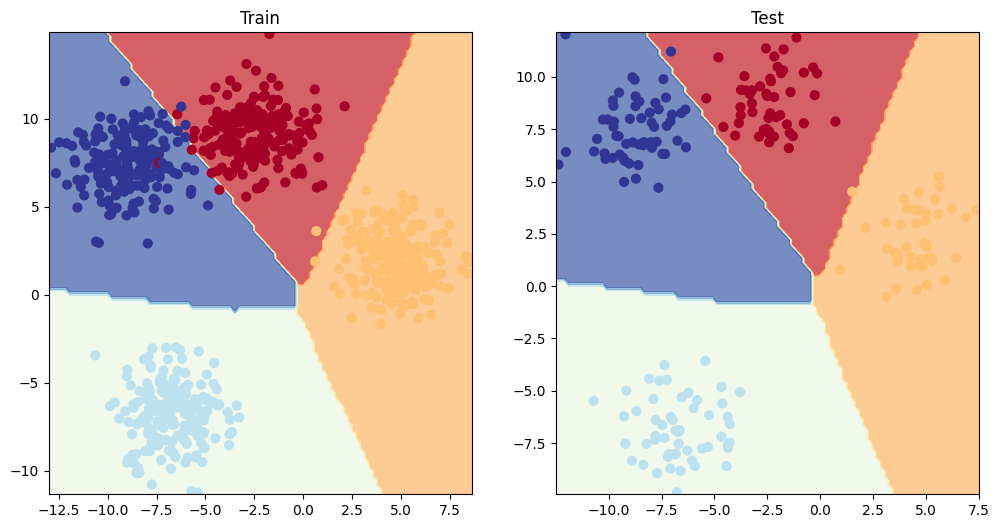

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model4, X_blob_train, Y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model4, X_blob_test, Y_blob_test)